# Contexte

Ce projet rentre dans la formation "Artificial Intelligence for robotics with Python" proposée par Micro Club. A travers ce court projet vous aurez à revoir les principes de classification utilisant des méthodes de Machine Learning classique comme vus durant la séance 3. 

Ce projet se base sur ce [dataset](https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification) donnant les données CTG (cardiotocogramme) pour définir les taux de risques de maladie de foetus, donc l'objectif est de classer les différents cas en trois catégories : 
- Normal : 1
- Suspect : 2
- Malade : 3

Ainsi ce genre de projet vous permettra de vous entraîner sur de vrais problématiques. 

In [63]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

# Pré-traitement des données
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Pour tester les performances des modèles utilisés
from sklearn import metrics

# Classification
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

# Resampling 
from sklearn.utils import resample


# Charger les données

In [64]:
fetal_data = pd.read_csv("fetal_health.csv")
fetal_data

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.000,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.000,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.000,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.000,0.000,0.007,0.000,0.0,0.0,79.0,0.2,25.0,...,137.0,177.0,4.0,0.0,153.0,150.0,152.0,2.0,0.0,2.0
2122,140.0,0.001,0.000,0.007,0.000,0.0,0.0,78.0,0.4,22.0,...,103.0,169.0,6.0,0.0,152.0,148.0,151.0,3.0,1.0,2.0
2123,140.0,0.001,0.000,0.007,0.000,0.0,0.0,79.0,0.4,20.0,...,103.0,170.0,5.0,0.0,153.0,148.0,152.0,4.0,1.0,2.0
2124,140.0,0.001,0.000,0.006,0.000,0.0,0.0,78.0,0.4,27.0,...,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,2.0


## Subdiviser les données pour enlever tous les biais

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=target).copy()
y = df[target].copy()

y -= 1 # originally, the targets are 1-3; we will use 0-2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

## Analyse des données

Dans cette partie on va avoir une vue d'ensemble de nos données
- On tire le type des données
- La distribution des différentes classes
- Valeurs manquantes ou pas ? 
- Distribution des différentes variables

In [4]:
fetal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

On peut déjà voir qu'on a 22 colonnes dans notre tableau : 
- 21 caractéristiques 
- fetal_health qui constitue la classe cible de notre problème

On peut aussi voir que toutes les colonnes sont réelles et il n'y aucune valeur manquante ca nous évitera donc de faire un travail de remplacement de ces valeurs. On va voir maintenant la corrélation entre les différentes variables

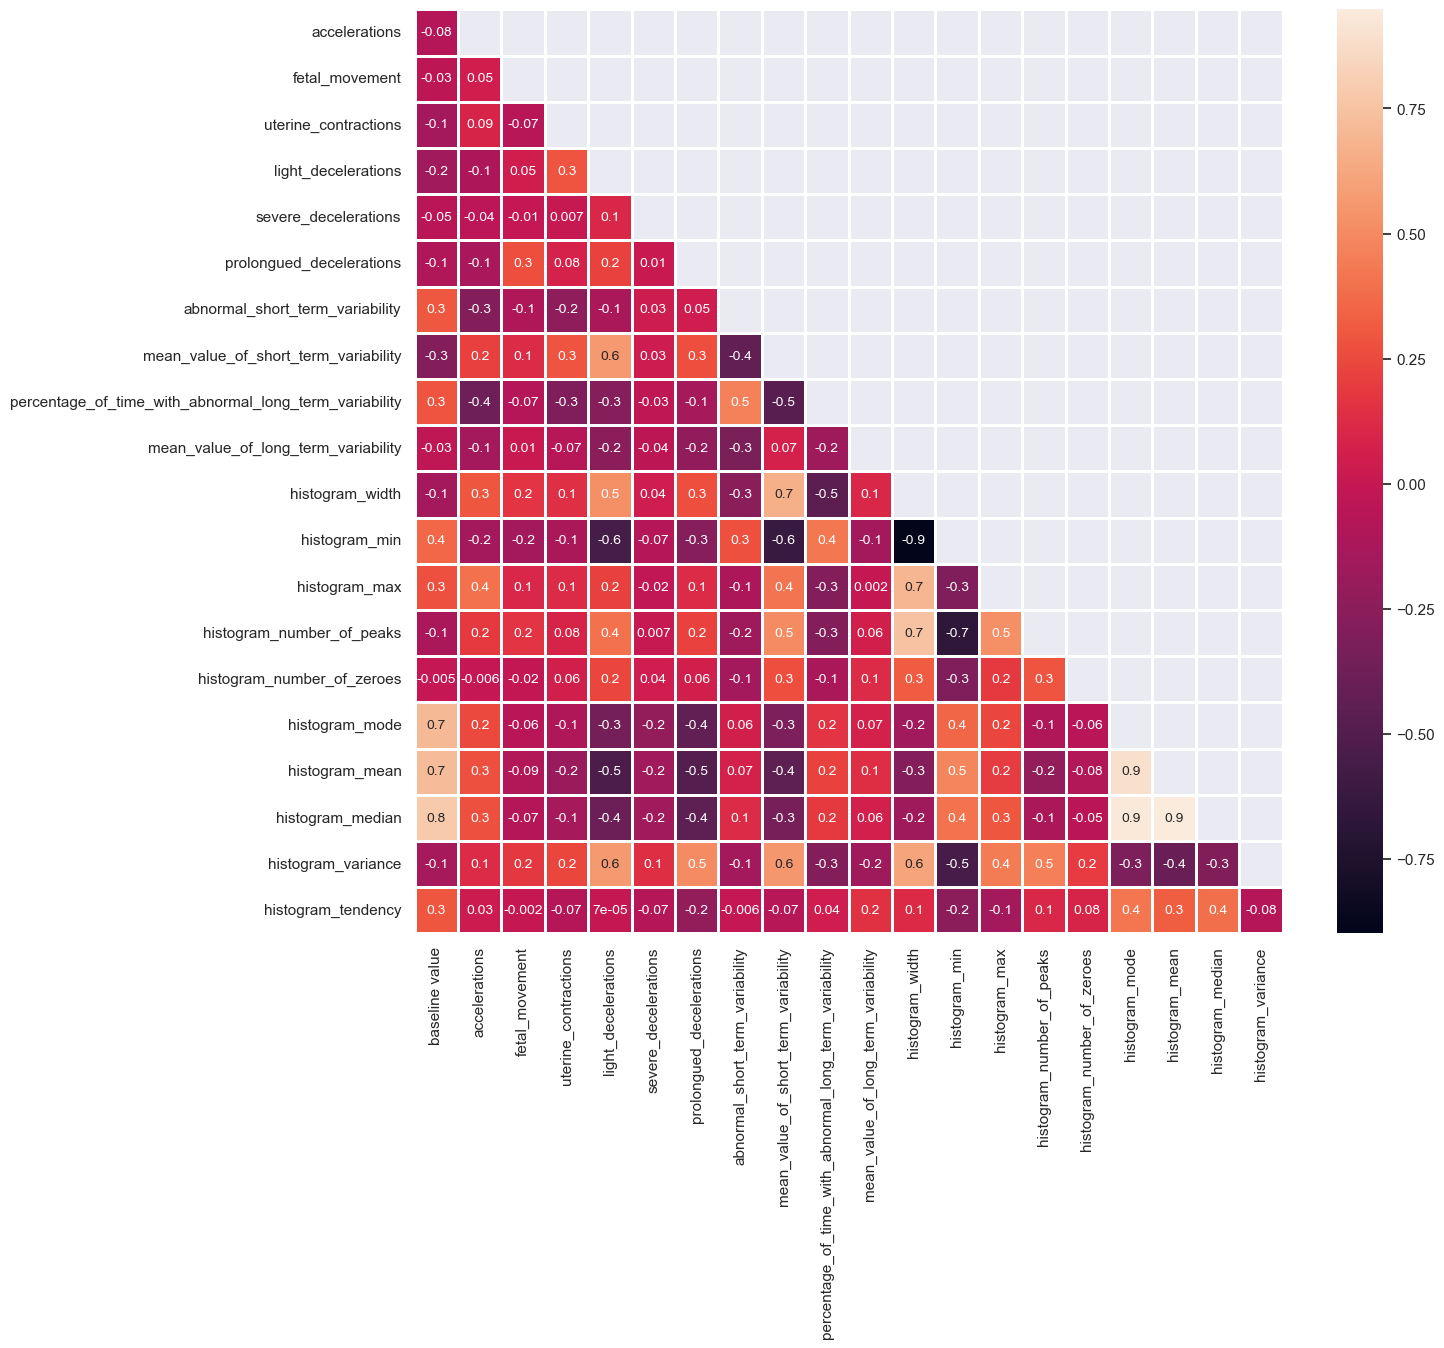

In [65]:
plt.figure(figsize=(14,12))
fetal_features = fetal_data.copy()
fetal_features.drop(['fetal_health'], axis=1, inplace=True)
mask = np.triu(np.ones_like(fetal_features.corr(), dtype=bool))
sns.heatmap(fetal_features.corr().iloc[1:,:-1], mask=mask[1:,:-1], annot=True, fmt=".1g", linewidths=2.0, annot_kws={"size": 10})
plt.show()

On peut voir certaines variables fortement corrélée ce qui nous indique que par la suite on va éventuellement supprimer quelques unes de ces colonnes pour chercher un meilleur résultat. Ce sera considéré dans un second temps.

On observe maintenant la corrélation qui existe entre chaque feature et la classe cible qu'on a 

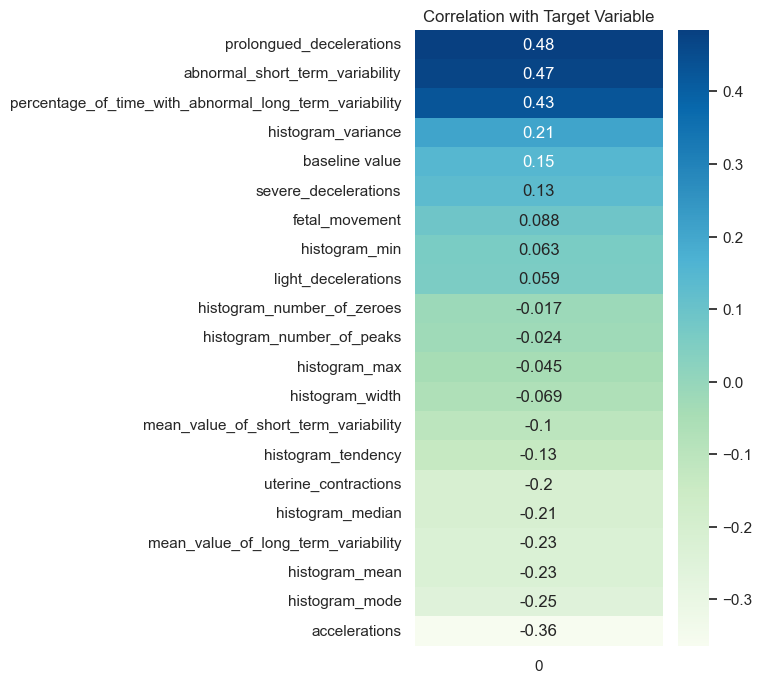

In [66]:
# Create a correlation matrix with target variable
corr_with_target = fetal_features.corrwith(fetal_data.fetal_health)

# Sort features by correlation with target variable
corr_with_target = corr_with_target.sort_values(ascending=False)

# Plot the heatmap
plt.figure(figsize=(4, 8))
sns.heatmap(corr_with_target.to_frame(), cmap='GnBu', annot=True)
plt.title('Correlation with Target Variable')
plt.show()

On peut ainsi voir que certaines features ont quasi aucune corrélation avec la classe de sortie (corrélation proche de 0) donc probablement seront inutile dans notre problème, à voir plus tard

In [9]:
fetal_data["fetal_health"].value_counts() / len(fetal_data["fetal_health"]) * 100

1.0    77.845720
2.0    13.875823
3.0     8.278457
Name: fetal_health, dtype: float64

- On peut voir qu'ici on a un problème de classification assez déséquilibré et par conséquent on pourra voir que la classe 1 sera relativement simple à classifier par rapport aux deux autres classes
- Aussi pour l'évaluation du modèle on n'utilisera pas l'accuracy car ne permettant pas de rendre compte fidèlement de la qualité du modèle dans une telle situation (classe déséquilibrée)
- On va effectuer l'évaluation du modèle par rapport au F1-Score et le AUC-Score

On va maintenant observer les distributions des différentes variables

In [17]:
len(features)

21

C:\Users\dell\AppData\Local\Temp\ipykernel_31312\3279665218.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


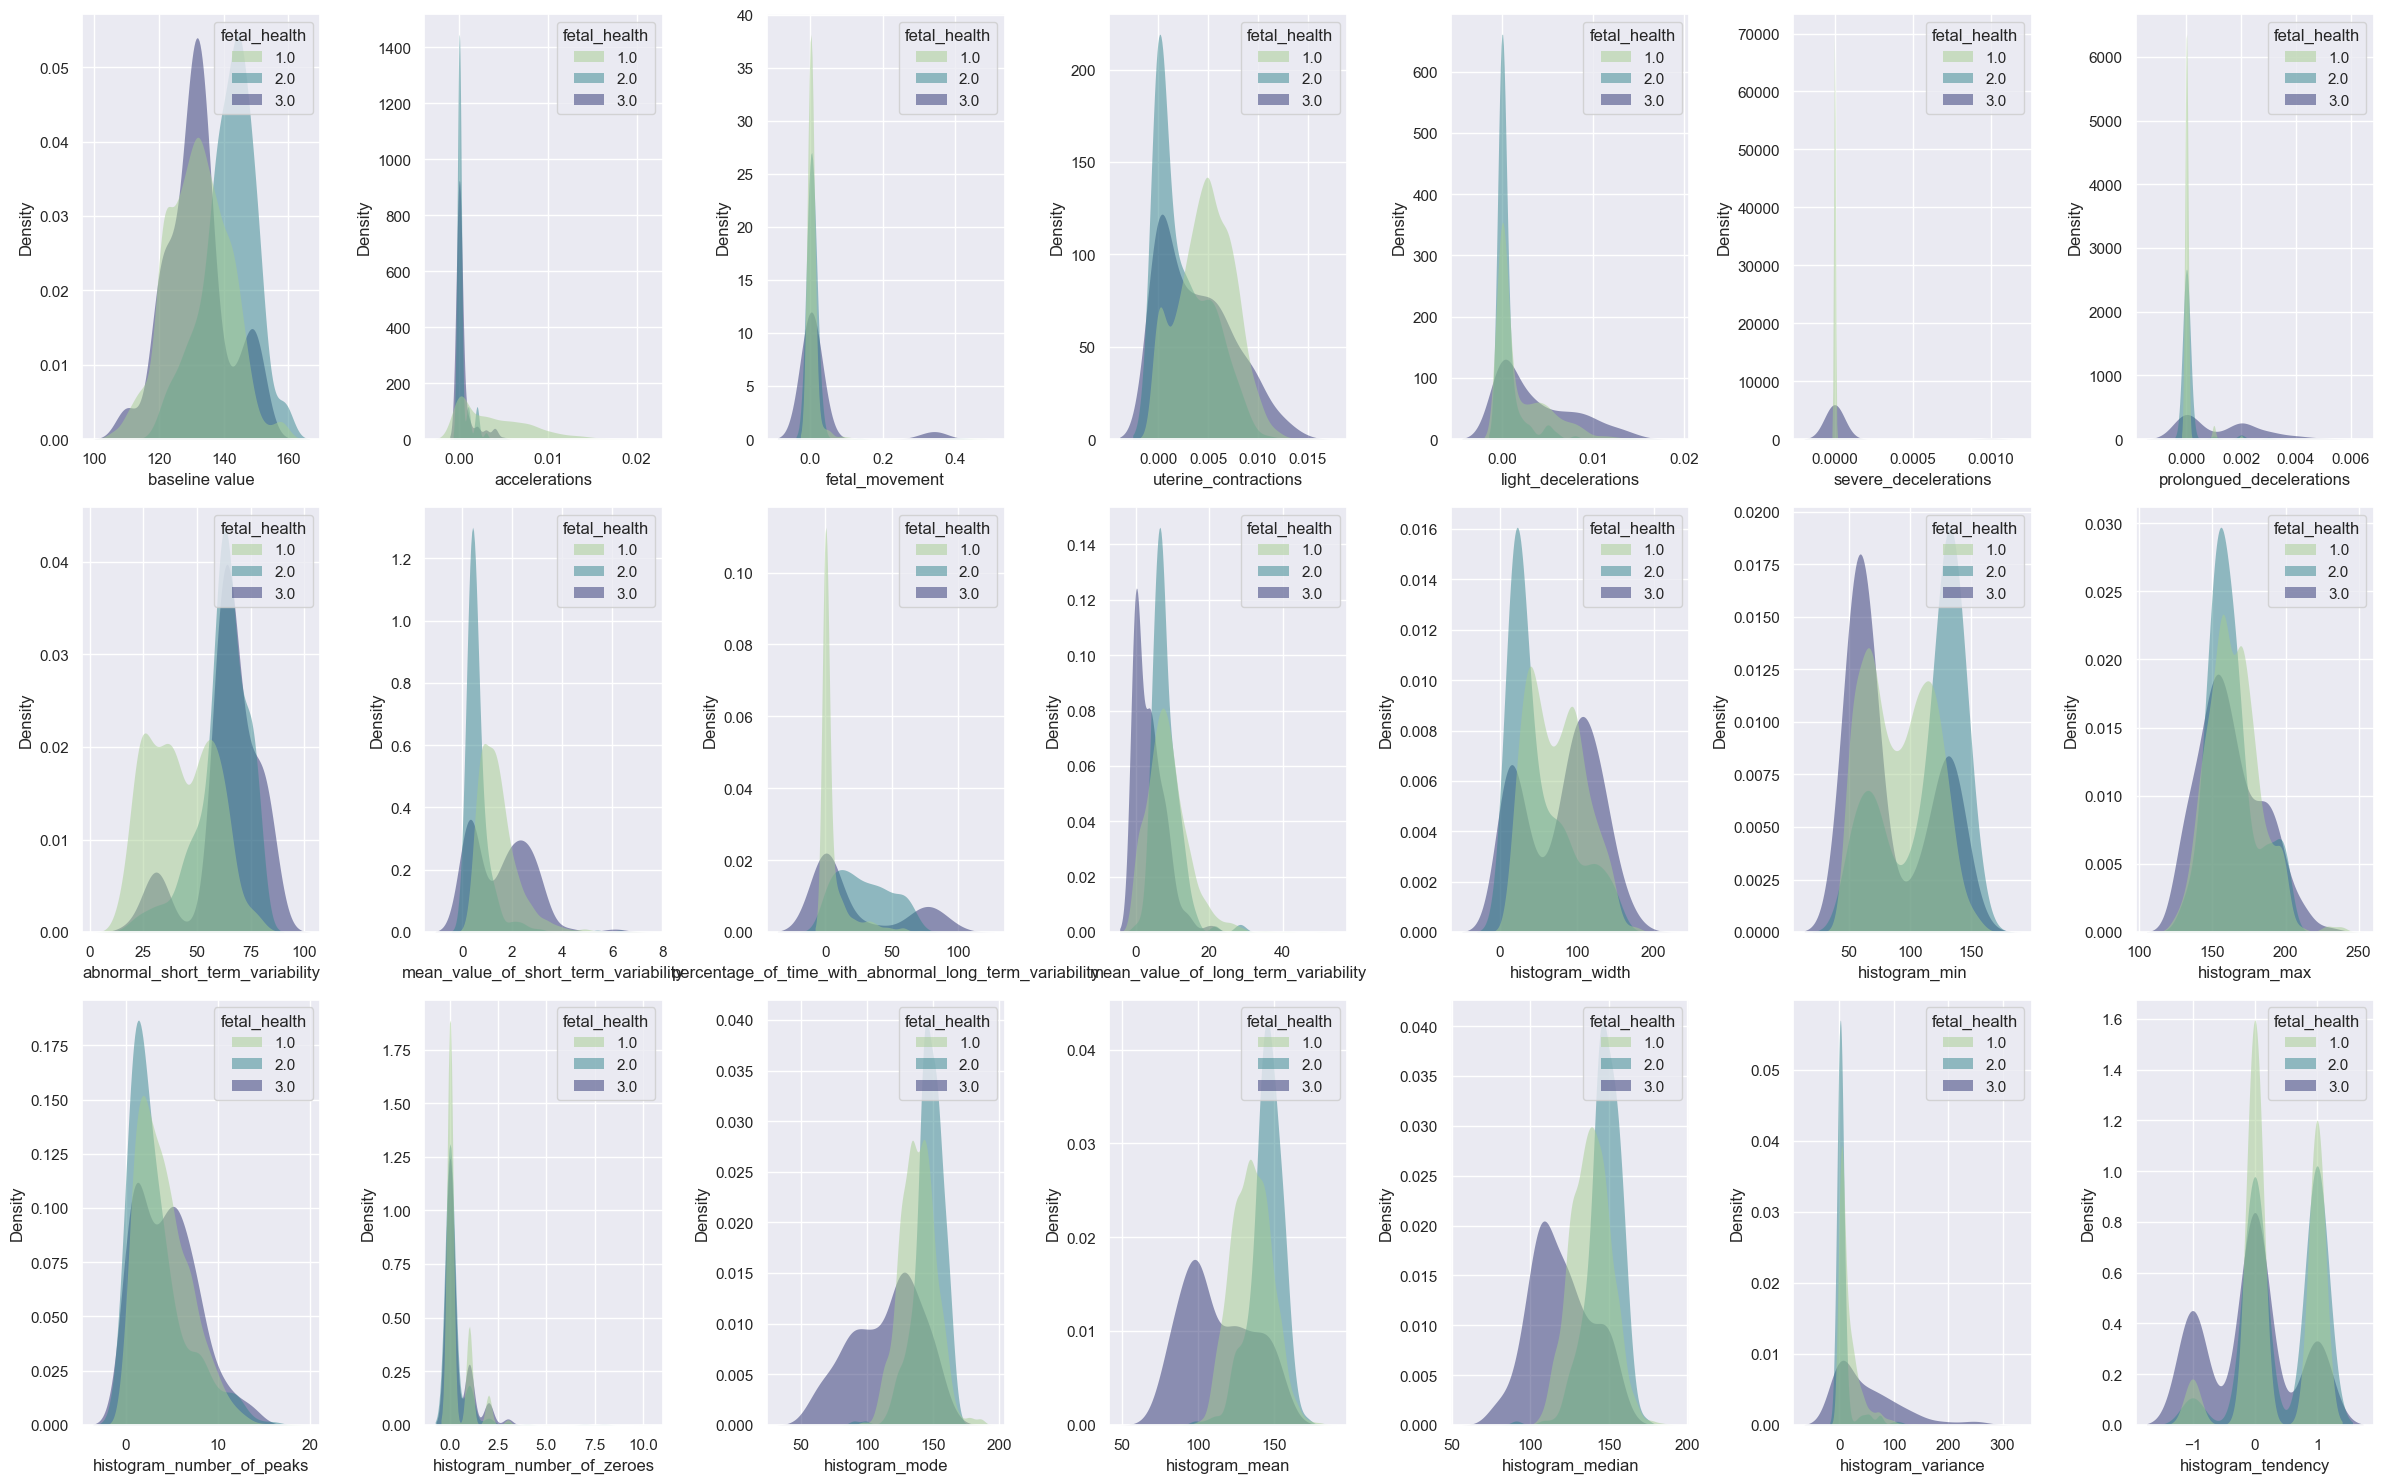

In [21]:
features = fetal_features.columns
plt.figure(figsize=(24, 15))
i = 1
for feature in features : 
   plt.subplot(3, 7, i)
   sns.kdeplot(
      data=fetal_data, x=feature, hue="fetal_health",
      fill=True, common_norm=False, palette="crest",
      alpha=.5, linewidth=0
   )
   i += 1
plt.tight_layout()

Se basant sur ces distributions on peut déjà voir que la classification sera relativement complexe puisque les distributions entre les trois classes sont relativement similaire dans une bonne partie des caractéristiques de notre problème

## Préparation des données

In [22]:
fetal_features.describe().T

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.0,133.303857,9.840844,106.0,126.000,133.000,140.000,160.000
accelerations,2126.0,0.003178,0.003866,0.0,0.000,0.002,0.006,0.019
fetal_movement,2126.0,0.009481,0.046666,0.0,0.000,0.000,0.003,0.481
uterine_contractions,2126.0,0.004366,0.002946,0.0,0.002,0.004,0.007,0.015
light_decelerations,2126.0,0.001889,0.002960,0.0,0.000,0.000,0.003,0.015
severe_decelerations,2126.0,0.000003,0.000057,0.0,0.000,0.000,0.000,0.001
prolongued_decelerations,2126.0,0.000159,0.000590,0.0,0.000,0.000,0.000,0.005
abnormal_short_term_variability,2126.0,46.990122,17.192814,12.0,32.000,49.000,61.000,87.000
mean_value_of_short_term_variability,2126.0,1.332785,0.883241,0.2,0.700,1.200,1.700,7.000
percentage_of_time_with_abnormal_long_term_variability,2126.0,9.846660,18.396880,0.0,0.000,0.000,11.000,91.000


On peut voir ici que les caractéristiques ne sont pas normalisées et donc un travail de normalisation doit être fait, pour se faire on va utiliser StandarScaler de Scikitlearn. Pour éviter tout Data Leakage on va subdiviser notre jeux de données en jeux d'entrainement et un autre de test et normaliser chacun indépendemment

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_train = X_train.copy()
df_test = X_test.copy()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Suite

M'inspirer de [ca](https://www.kaggle.com/code/yuvalaltman/fetal-health-classification)
- Correlation entre les variables et le target
- Features selection (ranking, PCA...)
- Des graphiques de distribution avec Seaborn
- Voir la préparation des données (standard scaler)
- Mettre en place les métriques d'évaluation
- Mettre cross validation avec RepeatedStratifiedKFold (voir l'inspiration)
- Investiguez l'utilisation de différents classifieurs (KNN, SVM, Random Forest, faire un ensemble learning entre plusieurs)
- Investigez ensuite des classifieurs comme XGBoost et suivre l'inspiration du notebook 
    - Voir comment l'optimiser
    - Voir comment avoir le meilleur modèle possible
- Investiguez l'utilisation de méthodes de Features selection
    - Ranking 
    - PCA
- Ajouter la corrélation des caractéristiques avec la sortie